### Preprocessing of Chevrier dataset
This noteboook provides codes for preprocessing of the dataset described in 
https://www.sciencedirect.com/science/article/pii/S0092867417304294?via%3Dihub#mmc2 . 
The files downloaded from the cytobank were passed thorugh chevrier_correct_fcs.R script,
since they were corrupted and it was not possible to load them directly into jupyter notebook. The cluster identity (cell-types) were obtained by reading out information from figure 2f (cell-type identity of the clusters provided with the data).

In [120]:
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import os 
import glob
from FlowCytometryTools import FCMeasurement
from collections import Counter
import pdb
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import xlrd
from collections import Counter
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import umap
reducer = umap.UMAP()
import matplotlib.cm as cm

In [166]:
# set the path!
wd = os.getcwd()
path = os.path.abspath(os.path.join(wd,"..","..","data/Dataset5/"))

### Collecting meta-information
The meta-information was collected from the cytobank webpage as well as from the article (description and figures).



In [122]:
### panel-experiment information from cytobank
panel_exp_dict = dict()
panel_exp_dict['experiment_102279_files'] = 'tcell_subset_panel'
panel_exp_dict['experiment_101718_files'] = 'tam_panel'
panel_exp_dict['experiment_101725_files'] = 'tcell_panel'
panel_exp_dict['experiment_102007_files'] = 'tam_subset_panel'

In [130]:
### cell-type information was read out from Figure 2f in the paper:
# TAM panel
tam_cluster_identity = dict()
tam_cluster_identity['22'] = 'pDC'
tam_cluster_identity['6'] = 'NK cells'
tam_cluster_identity['12'] = 'B cells'
tam_cluster_identity['14'] = 'Unknown'
tam_cluster_identity['16'] = 'Plasma cells'
tam_cluster_identity['20'] = 'DC'
for x in ['24','18','11','21','25','3','10']:
    tam_cluster_identity[x] = 'Non immune cells'
for x in ['5','1','8']:
    tam_cluster_identity[x] = 'Myeloid cells'
for x in ['4','13','9','0','15','23','19','17','2','7']:
    tam_cluster_identity[x] = 'T cells'
    
# TAM panel subset
tam_subset_cluster_identity = dict()
for x in range(16+1):
    tam_subset_cluster_identity[str(x)] = 'Myeloid cells' 

# Tcell panel
tcell_cluster_identity = dict()
tcell_cluster_identity['23'] = 'pDC'
tcell_cluster_identity['5'] = 'NK cells'
tcell_cluster_identity['18'] = 'Plasma cells'
tcell_cluster_identity['15'] = 'B cells'
tcell_cluster_identity['22'] = 'Granulocytes'
for x in ['28','17','16','25','14','4','21','10','20']:
    tcell_cluster_identity[x] = 'Non immune cells'
for x in ['26','27','6','1','11']:
    tcell_cluster_identity[x] = 'Myeloid cells'
for x in ['9','29','19','3','7','0','13','24','8','2','12']:
    tcell_cluster_identity[x] = 'T cells'
    
# Tcell panel subset
tcell_subset_cluster_identity = dict()
for x in range(21+1):
    tcell_subset_cluster_identity[str(x)] = 'T cells' 


In [131]:
### antibodies (according to the description and supplementary material)
fname = 'antibodies.xlsx'
xl_file = pd.ExcelFile(path+fname)
dfs = {sheet_name: xl_file.parse(sheet_name) 
          for sheet_name in xl_file.sheet_names}
#display(dfs)
df_anti_tam = pd.read_excel(path+fname, sheet_name='Sheet1')
df_anti_tcell = pd.read_excel(path+fname, sheet_name='Sheet2')

anti_tam = dict(zip([x+'Di' for x in df_anti_tam.loc[:,'Metal Tag']],
                    df_anti_tam.loc[:,'Target']))

anti_tcell = dict(zip([x+'Di' for x in df_anti_tcell.loc[:,'Metal Tag']],
                    df_anti_tcell.loc[:,'Target']))

# CD86, CD20, CD206, CD68, and CD15 were excluded from the analysis to remove markers
# not expressed on T cells and likely to add noise in the cluster generation process.
# CD7 was also excluded from the PhenoGraph clustering since this marker split most clusters
# into CD7+ and CD7- fractions without a clear biological meaning and simultaneously reduced
# the impact of more biologically relevant markers on the clustering

### Summarize information about all the files

In [132]:
data_dir=path+'data_corrected/'
files = []
for root, directories, filenames in os.walk(data_dir):
    for file in filenames:
        if '.fcs' in file:
            files.append(os.path.join(root, file))
print(len(files))            
file_info = dict()
for f in files:
    idx = f.split(data_dir)[-1]
    file_info[idx] = dict()
    file_info[idx]['sample'] = f.split('/')[-1].split('.')[0]
    file_info[idx]['experiment'] = f.split('/')[-2]
    file_info[idx]['panel'] = panel_exp_dict[file_info[idx]['experiment']]
    df = FCMeasurement(ID='Sample', datafile=f)
    file_info[idx]['ncells'] = df.data.shape[0]
    file_info[idx]['nchannels'] = df.data.shape[1]
    file_info[idx]['channels'] = [x for x in df.data.columns if 'Di' in x]

308


In [133]:
# summarize the information about all files
summary_df = pd.DataFrame(index=file_info[list(file_info.keys())[0]].keys(),
                           columns=file_info.keys())

for f in file_info.keys():
    summary_df.loc[:,f] = pd.DataFrame.from_dict(file_info[f], orient='index')
summary_df = summary_df.transpose()
summary_df.head(2)


,sample,experiment,panel,ncells,nchannels,channels
experiment_102007_files/rcc7.fcs,rcc7,experiment_102007_files,tam_subset_panel,11842,55,"[beadDist, Y89Di, Pd102Di, Pd104Di, Pd105Di, P..."
experiment_102007_files/rcc17.fcs,rcc17,experiment_102007_files,tam_subset_panel,14,55,"[beadDist, Y89Di, Pd102Di, Pd104Di, Pd105Di, P..."


In [134]:
### clinical info
fname = 'clinical_info.xlsx'
xl_file = pd.ExcelFile(path+fname)
dfs = {sheet_name: xl_file.parse(sheet_name) 
          for sheet_name in xl_file.sheet_names}
df_clinical = pd.read_excel(path+fname, sheet_name='Sheet3')
df_batch = pd.read_excel(path+fname, sheet_name='Sheet1')
df_clinical = df_clinical.merge(df_batch, right_on='Sample ID', 
                                left_on=df_clinical.columns[0])

# add clinical info to the summary_df
df_clinical['sample'] = ['rcc'+str(x) for x in df_clinical.iloc[:,0]]
summary_df = summary_df.merge(df_clinical, on='sample')
summary_df.head(2)
### excluded samples: rcc61 (outlier for myeloid compartment); 
# rcc25, rcc17 (insufficient immune cell number)

,sample,experiment,panel,ncells,nchannels,channels,Code used in the file name,Tissue Bank ID#,Subtype,Gender,...,Date Last Follow-up,Status (Alive/Dead),Date of Death,Time to death,Length FU (yr),Cause Death,Case Note,Sample ID,Site,Grade_y
0,rcc7,experiment_102007_files,tam_subset_panel,11842,55,"[beadDist, Y89Di, Pd102Di, Pd104Di, Pd105Di, P...",7,62224,ccRCC,M,...,2015-09-10,A,NaT,NaN,NaN,NaN,NaN,7,UHN,3
1,rcc7,experiment_101718_files,tam_panel,30365,55,"[Y89Di, Pd102Di, Pd104Di, Pd105Di, Pd106Di, Pd...",7,62224,ccRCC,M,...,2015-09-10,A,NaT,NaN,NaN,NaN,NaN,7,UHN,3


### Data preprocessing

In [135]:
### combine files (rbind) per experiment
experiments = list(set(summary_df['experiment']))

data_series = dict()#pd.Series({})
for exp in experiments:
    files_exp = [x for x in files if exp in x]
    exp_data_series = dict()
    for f in files_exp:
        name = f.split('/')[-1].split('.')[0]
        exp_data_series[name] = FCMeasurement(ID='Sample', datafile=f).data
    data_series[exp] = pd.concat(exp_data_series, axis=0)
    

In [136]:
### correct the names across experiments and add the cell-type information
col_names = []
data_series_pp = dict()
for key in data_series.keys():
    df = data_series[key]
    col_tmp = df.columns
    if(panel_exp_dict[key].split('_')[0]=='tam'):
        anti_dict = anti_tam.copy()
        panel = "tam_panel"
        cell_type_dict = tam_cluster_identity
        if('subset' in panel_exp_dict[key]):
            cell_type_dict = tam_subset_cluster_identity
    else:
        anti_dict = anti_tcell.copy()
        panel = "tcell_panel"
        cell_type_dict = tcell_cluster_identity
        if('subset' in panel_exp_dict[key]):
            cell_type_dict = tcell_subset_cluster_identity
    anti_dict['phenograph'] = 'metadata_phenograph'
    anti_dict['PhenoGraph'] = 'metadata_phenograph'
    for t in col_tmp:
        if(t not in anti_dict.keys()):
            anti_dict[t] = 'metadata_'+t
    col_new = [anti_dict[x] for x in col_tmp]
    df.columns = col_new
    df['metadata_panel'] = panel
    df['metadata_celltype'] = [cell_type_dict[str(int(x))] for x in df['metadata_phenograph']]
    col_names.extend(df.columns)
    data_series[key] = df
col_names_count = Counter(col_names)


In [137]:
# merge data across experiments
data_all_merged = pd.concat(data_series, axis=0)
data_all_merged['metadata_sample'] = data_all_merged.index.get_level_values(1)
data_all_merged['metadata_batch'] = data_all_merged.index.get_level_values(0)
# remove samples 61,25 and 17, as indicated in the manuscripts
data_all_merged = data_all_merged.drop(labels = ['rcc61','rcc25','rcc17'],axis=0, level=1)
data_all_merged.shape

/Users/joannaf/anaconda3/envs/dl/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


(4705750, 92)

In [138]:
### create an index merging the important information
#(for compatibility with other parts of the pipeline)
batch_unique = list(set(data_all_merged['metadata_batch']))
batch_dict = dict(zip(batch_unique, ['batch'+str(x+1) for x in range(len(batch_unique))]))
sample_unique = list(set(data_all_merged['metadata_sample']))
sample_dict = dict(zip(sample_unique, ['sample'+str(x+1) for x in range(len(sample_unique))]))

batch_renamed = [batch_dict[x] for x in data_all_merged['metadata_batch']]
data_all_merged['metadata_experiment'] = data_all_merged['metadata_batch']
data_all_merged['metadata_batch'] = batch_renamed
sample_renamed = [sample_dict[x] for x in data_all_merged['metadata_sample']]
sample_renamed = [sample_dict[x] for x in data_all_merged['metadata_sample']]
data_all_merged['metadata_sample_org'] = data_all_merged['metadata_sample']
data_all_merged['metadata_sample'] = sample_renamed
panel_renamed = [x.replace('_','.') for x in data_all_merged['metadata_panel']]
celltype_renamed = ['celltype'+x.replace(' ','.') for x in data_all_merged['metadata_celltype']]
idx = ['_'.join([a,b,c,d]) for a,b,c,d in zip(batch_renamed, sample_renamed, panel_renamed,celltype_renamed)]
data_all_merged.index = idx

In [139]:
### preprocessing steps as described in the paper
def arcsinh(x, c=5):
    if(x is not np.nan):
        x = np.log(x/c + np.sqrt((x/c)**2 +1))
    return(x)

data_all_merged = data_all_merged.apply(lambda x: arcsinh(x) if 'metadata' not in x.name else x)


In [140]:
data_all_merged.head(2)

,CCR7,CD119 (IFN-g R a chain),CD11b,CD11c,CD123,CD127,CD13,CD134,CD14,CD15,...,metadata_Yb170Di,metadata_barcode,metadata_beadDist,metadata_celltype,metadata_panel,metadata_phenograph,metadata_sample,metadata_batch,metadata_experiment,metadata_sample_org
batch1_sample5_tam.panel_celltypeNK.cells,NaN,0.106002,0.173622,NaN,0.0,NaN,0.000000,NaN,0.009175,NaN,...,NaN,4.0,69.986053,NK cells,tam_panel,6.0,sample5,batch1,experiment_101718_files,rcc7
batch1_sample5_tam.panel_celltypeNon.immune.cells,NaN,0.215915,0.270593,NaN,0.0,NaN,0.404903,NaN,0.000000,NaN,...,NaN,4.0,69.775345,Non immune cells,tam_panel,11.0,sample5,batch1,experiment_101718_files,rcc7


In [143]:
# experiments with all cells
full_exp = [u for u,v in panel_exp_dict.items() if 'subset' not in v]
data_all_merged = data_all_merged.loc[data_all_merged['metadata_experiment'].isin(full_exp),:]
table = pa.Table.from_pandas(data_all_merged)
pq.write_table(table, path+'chevrier_data_pooled_full_panels.parquet')
#pq.write_table(table, path+'chevrier_data_pooled_panels.parquet')


In [148]:
#cell_per_group.iloc[0:50]
sample_ncell = data_all_merged.groupby(['metadata_sample']).metadata_barcode.count().sort_values()
dict(zip(sample_ncell.index, sample_ncell))

{'sample1': 1517,
 'sample40': 1944,
 'sample67': 1972,
 'sample12': 3733,
 'sample47': 3839,
 'sample36': 4199,
 'sample26': 5144,
 'sample71': 6480,
 'sample13': 7352,
 'sample3': 10719,
 'sample16': 13301,
 'sample54': 13351,
 'sample75': 14876,
 'sample51': 15979,
 'sample19': 17720,
 'sample45': 18057,
 'sample9': 18455,
 'sample70': 19006,
 'sample37': 19699,
 'sample61': 20457,
 'sample14': 21064,
 'sample15': 21483,
 'sample42': 26183,
 'sample69': 27559,
 'sample62': 27804,
 'sample43': 28805,
 'sample33': 29688,
 'sample48': 30409,
 'sample30': 31124,
 'sample34': 31861,
 'sample6': 32967,
 'sample55': 33319,
 'sample35': 33661,
 'sample46': 34006,
 'sample4': 34810,
 'sample17': 35012,
 'sample7': 36644,
 'sample11': 36965,
 'sample32': 37023,
 'sample29': 37292,
 'sample68': 37321,
 'sample73': 38153,
 'sample65': 38528,
 'sample8': 39428,
 'sample22': 42623,
 'sample25': 42850,
 'sample39': 43008,
 'sample28': 44512,
 'sample38': 44814,
 'sample44': 44916,
 'sample23': 455

In [ ]:
############################   sanity checks  ##############################

In [174]:
def plot_tsne(data, do_pca=True, n_plots=2, iter_=500, pca_components=20, save_as=None, folder_name='figures'):
    ''' 
    Function to generate t-sne plot 
    inputs: 
        data: cell x markers: has the labels as index!! eg. Data23_Panel1_tx_NR4_Patient9
        do_pca: performs pca prior to t-sne, no downsampling there
        n_plots: Tries different perplexity values, 
        iter_ : fitting 
        pca_components: PCs
    '''
    Labels = list(data.index)
    if do_pca: 
        pca = PCA(n_components=pca_components)
        data = pca.fit_transform(data)
    for i in range(n_plots):
        perplexity_ = 10* (i + 1)
        tsne = TSNE(n_components=2,verbose=1,perplexity=perplexity_,n_iter=iter_)
        X_tsne = tsne.fit_transform(data)
        Xf = pd.DataFrame(X_tsne)
        Xf.columns = ["t-sne1", "t-sne2"]
        Xf['labels'] = Labels
        tsne_plot = sns.lmplot("t-sne1", "t-sne2",hue="labels",data=Xf, fit_reg=False, scatter_kws={'alpha': 0.1})
        plt.title('Plot: t-SNE projection of the dataset perplexity = {}, iter = {}'.format(perplexity_, iter_), fontsize=15)
        if save_as is not None:
            plt.savefig(os.path.join(folder_name, save_as+'_p'+str(perplexity_)))
            plt.close()
        else:
            #plt.show()
            tsne_plot

def scale(x):
    p99 = np.percentile(x,99)
    x[x>p99] = p99
    x = (x - np.min(x)) / (np.max(x) - np.min(x))
    return(x)

def prep_for_tsne(data, max_cells=2000, random_state=345):
    df = data.copy()
    np.random.seed(random_state)
    df['metadata_number'] = range(df.shape[0])
    selected_cells = df.loc[:,['metadata_celltype','metadata_number']].groupby('metadata_celltype',group_keys=False).apply(lambda x: x.sample(min(len(x),max_cells)))
    df = df.iloc[selected_cells['metadata_number'],:]
    df = df.loc[:,~df.columns.str.startswith('metadata')]
    cts = [x.split('_')[-1].split('celltype')[-1] for x in list(df.index)]
    df.index = cts
    df = df.apply(lambda x: scale(x), axis=0)
    return(df)


In [150]:
tam_df = data_all_merged.loc[data_all_merged['metadata_panel']=='tam_panel',:]#~data_all_merged.columns.str.startswith('metadata')]
print(tam_df.shape)
tam_df = tam_df.dropna(axis=1)
tam_df = prep_for_tsne(tam_df)
print(tam_df.shape)

tcell_df = data_all_merged.loc[data_all_merged['metadata_panel']=='tcell_panel',:]#~data_all_merged.columns.str.startswith('metadata')]
print(tcell_df.shape)
tcell_df = tcell_df.dropna(axis=1)
tcell_df = prep_for_tsne(tcell_df)
print(tcell_df.shape)

(1586418, 94)
(18000, 35)
(1830229, 94)
(15867, 27)


[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 18000 samples in 0.012s...
[t-SNE] Computed neighbors for 18000 samples in 3.108s...
[t-SNE] Computed conditional probabilities for sample 1000 / 18000
[t-SNE] Computed conditional probabilities for sample 2000 / 18000
[t-SNE] Computed conditional probabilities for sample 3000 / 18000
[t-SNE] Computed conditional probabilities for sample 4000 / 18000
[t-SNE] Computed conditional probabilities for sample 5000 / 18000
[t-SNE] Computed conditional probabilities for sample 6000 / 18000
[t-SNE] Computed conditional probabilities for sample 7000 / 18000
[t-SNE] Computed conditional probabilities for sample 8000 / 18000
[t-SNE] Computed conditional probabilities for sample 9000 / 18000
[t-SNE] Computed conditional probabilities for sample 10000 / 18000
[t-SNE] Computed conditional probabilities for sample 11000 / 18000
[t-SNE] Computed conditional probabilities for sample 12000 / 18000
[t-SNE] Computed conditional probabilities for sam

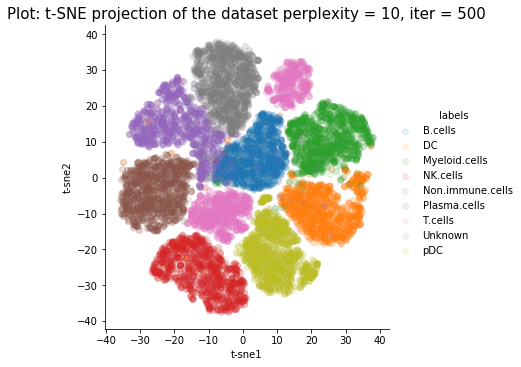

In [175]:
plot_tsne(tam_df, n_plots=1)
plt.savefig(path+'/plots/chevrier_tsne_tam_panel.png', bbox_inches='tight')

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 15867 samples in 0.010s...
[t-SNE] Computed neighbors for 15867 samples in 3.368s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15867
[t-SNE] Computed conditional probabilities for sample 2000 / 15867
[t-SNE] Computed conditional probabilities for sample 3000 / 15867
[t-SNE] Computed conditional probabilities for sample 4000 / 15867
[t-SNE] Computed conditional probabilities for sample 5000 / 15867
[t-SNE] Computed conditional probabilities for sample 6000 / 15867
[t-SNE] Computed conditional probabilities for sample 7000 / 15867
[t-SNE] Computed conditional probabilities for sample 8000 / 15867
[t-SNE] Computed conditional probabilities for sample 9000 / 15867
[t-SNE] Computed conditional probabilities for sample 10000 / 15867
[t-SNE] Computed conditional probabilities for sample 11000 / 15867
[t-SNE] Computed conditional probabilities for sample 12000 / 15867
[t-SNE] Computed conditional probabilities for sam

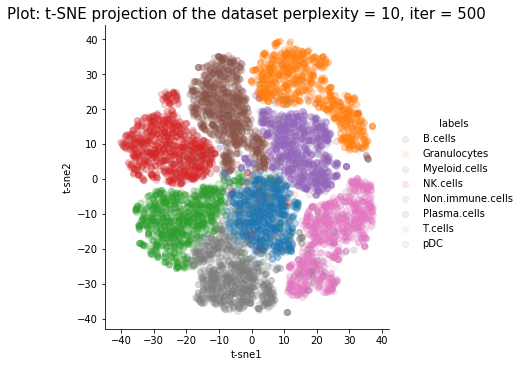

In [176]:
plot_tsne(tcell_df, n_plots=1)
plt.savefig(path+'/plots/chevrier_tsne_tcell_panel.png', bbox_inches='tight')